In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

# from multiprocessing import Pool

# from scipy.optimize import curve_fit
# from scipy.optimize import minimize

# from matplotlib.patches import Rectangle

from zernike.ZernikePolynomials import SquarePolynomials
from zernike.utils import *
from psf_utils import *

## Loading the wavefront data

In [2]:
filepath = "scan_example.h5"
with h5py.File(filepath, 'r') as f:
    phase_2d = f['/speckle_tracking/phase'][()]
    whitefield = f['/speckle_tracking/whitefield'][()]
    ref_img = f['/speckle_tracking/reference_image'][()]
    phase_x = f['/speckle_tracking/phase_x'][()]
    phase_y = f['/speckle_tracking/phase_y'][()]
    wavelength = f['/entry/instrument/source/wavelength'][()]
    pxsize = f['/entry/instrument/detector/x_pixel_size'][()]
    distance = f['/entry/instrument/detector/distance'][()]

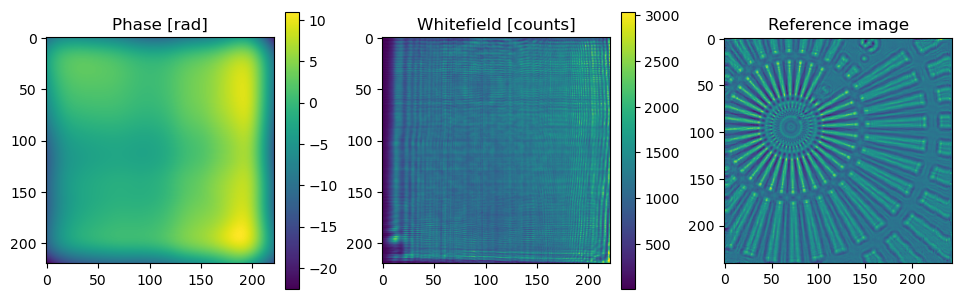

In [3]:
fig, axs = plt.subplots(1,3, figsize = (9.5,3), constrained_layout = True)
im = axs[0].imshow(phase_2d)
axs[0].set_title("Phase [rad]")
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(whitefield)
axs[1].set_title("Whitefield [counts]")
plt.colorbar(im, ax=axs[1])
axs[2].imshow(ref_img)
axs[2].set_title("Reference image")
plt.show()

We can see the wavefront has some left over tilt along *X*

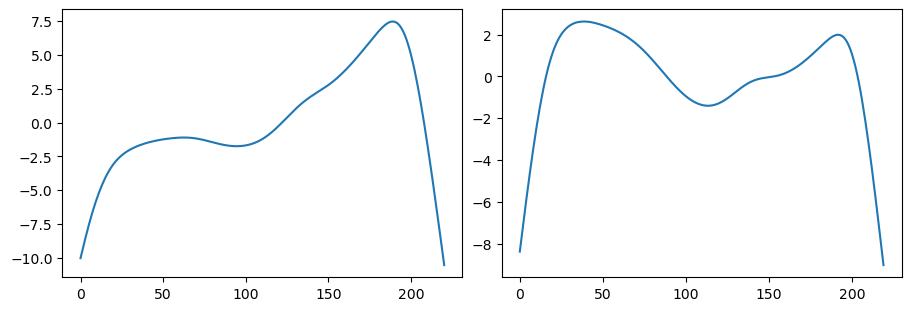

In [4]:
fig, axs = plt.subplots(1,2, figsize = (9,3), constrained_layout = True)
axs[0].plot(phase_x)
axs[1].plot(phase_y)
plt.show()

We can crop the pupil a bit and subtract the linear terms

In [5]:
phase_2d_trim = phase_2d[10:-5, 1:-15]
whitefield_trim = whitefield[10:-5, 1:-15]

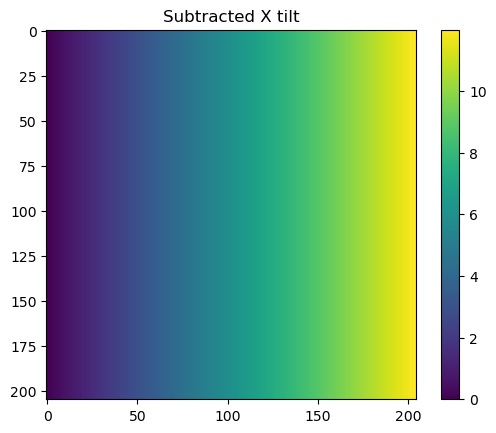

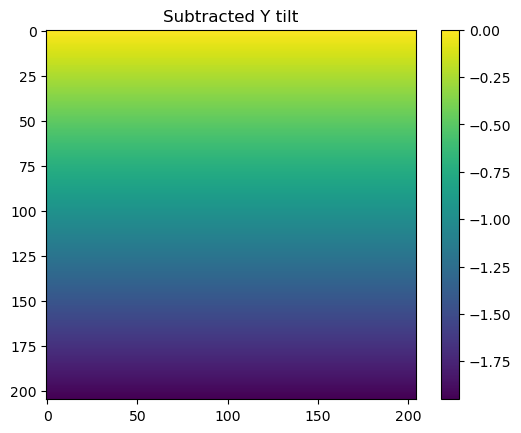

In [6]:
corrected_wavefront = subtract_linear_term(phase_2d_trim, plot = True)

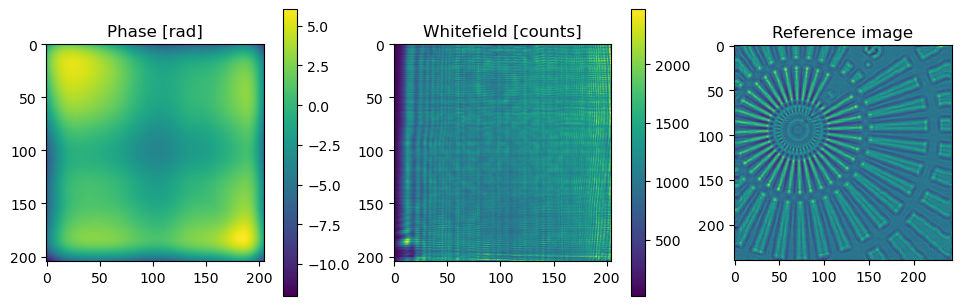

In [7]:
fig, axs = plt.subplots(1,3, figsize = (9.5,3), constrained_layout = True)
im = axs[0].imshow(corrected_wavefront)
axs[0].set_title("Phase [rad]")
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(whitefield_trim)
axs[1].set_title("Whitefield [counts]")
plt.colorbar(im, ax=axs[1])
axs[2].imshow(ref_img)
axs[2].set_title("Reference image")
plt.show()

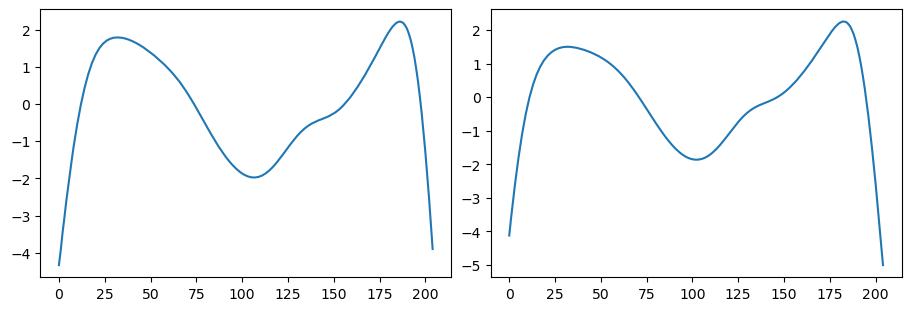

In [8]:
phase_x = np.mean(corrected_wavefront, axis=0)
phase_y = np.mean(corrected_wavefront, axis=1)
fig, axs = plt.subplots(1,2, figsize = (9,3), constrained_layout = True)
axs[0].plot(phase_x)
axs[1].plot(phase_y)
plt.show()

In [9]:
wavefront = corrected_wavefront

## Zernike decomposition of the wavefront

In [10]:
zernike_coeff = extract_square_coefficients_vectorized(wavefront)

Building design matrix...
Done


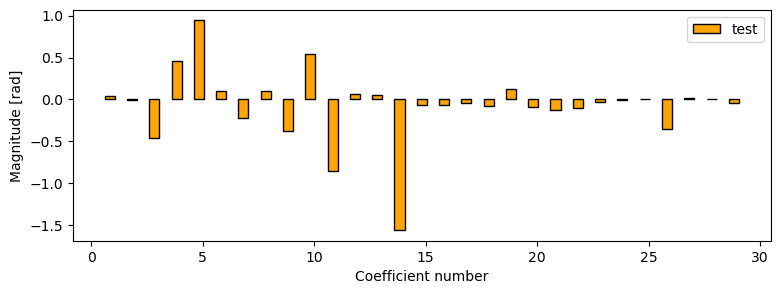

In [11]:
fig, ax = plt.subplots(figsize = (9,3), dpi=100)
x = np.arange(1,len(zernike_coeff)+1, 1) 
ax.bar(x[:]-0.175, zernike_coeff[:], color='orange', width = 0.45, edgecolor='black', label = "test")
ax.set_xlabel("Coefficient number")
ax.set_ylabel("Magnitude [rad]")
ax.legend()
plt.show()

In [12]:
rms = round(np.sqrt(np.nanmean((wavefront - np.nanmean(wavefront))**2)),2)
zernike = np.array(zernike_coeff)
rms_wavefront_zernike = round(np.sqrt(np.sum(zernike[:]**2)),2)
print(f"RMS of the wavefront is {rms} rad")
print(f"Sum of the zernike coefficients is {rms_wavefront_zernike} rad")

RMS of the wavefront is 2.32 rad
Sum of the zernike coefficients is 2.28 rad


In [13]:
f = 10.5e-3 # focal length of the MLLs 
NA = 55.7e-6/f/2 # NA
print(f"MLLs NA is {round(NA,4)}, and focal length is {f*1e3} mm")


MLLs NA is 0.0027, and focal length is 10.5 mm


In [14]:
# defocus value
a4 = zernike[3]
df = 3/2 * np.sqrt(5/2) * a4 * wavelength / (np.pi * NA**2)
print(f"Defocus value for the wavefront: {round(df*1e6,1)} um")

Defocus value for the wavefront: 3.4 um


In [15]:
a5 = zernike[4]
print(f"A5 value is: {round(a5,2)} rad")
alpha = round( np.degrees(3/2 * a5 * wavelength/ (np.pi * f * NA**2)), 4)
print(f"Misalignment roll angle: {alpha*1e3} mdeg")

A5 value is: 0.95 rad
Misalignment roll angle: 24.8 mdeg


In [16]:
# 90deg astigmatism correction 
a6 = zernike[5]
L = 3 * np.sqrt(5/2) * a6 * wavelength / (np.pi * NA**2)
print(f"The inter-lens distance correction: {round(L*1e6,1)} um")

The inter-lens distance correction: 1.5 um


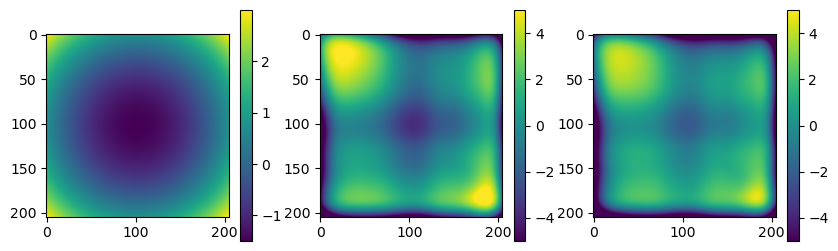

In [17]:
# Looking at the zernike terms 
square_poly = SquarePolynomials() 
shape = wavefront.shape
# Create coordinate grids
side_x = np.linspace(-1/np.sqrt(2), 1/np.sqrt(2), shape[1])
side_y = np.linspace(-1/np.sqrt(2), 1/np.sqrt(2), shape[0])

X, Y = np.meshgrid(side_x, side_y)
xdata = [X, Y]

defocus_term = square_poly.evaluate('S4', xdata, zernike_coeff[4])

fig, axs = plt.subplots(1,3, figsize = (10,3))
im = axs[0].imshow(defocus_term)
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(wavefront, vmin=-5, vmax=5)
plt.colorbar(im, ax = axs[1])
im = axs[2].imshow(wavefront - defocus_term, vmin=-5, vmax=5)
plt.colorbar(im, ax=axs[2])

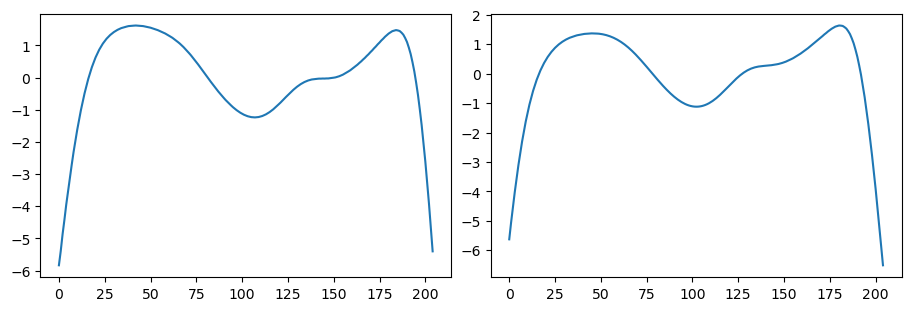

In [18]:
corrected_wavefront = wavefront - defocus_term
phase_x = np.mean(corrected_wavefront, axis=0)
phase_y = np.mean(corrected_wavefront, axis=1)
fig, axs = plt.subplots(1,2, figsize = (9,3), constrained_layout = True)
axs[0].plot(phase_x)
# axs[0].plot(phase_y)
axs[1].plot(phase_y)
plt.show()

## Building PSF

In [19]:
pad_length = 1000 # padding 
phase_pad, white_pad = make_pad(corrected_wavefront, whitefield_trim, pad_length = pad_length, fill = True)

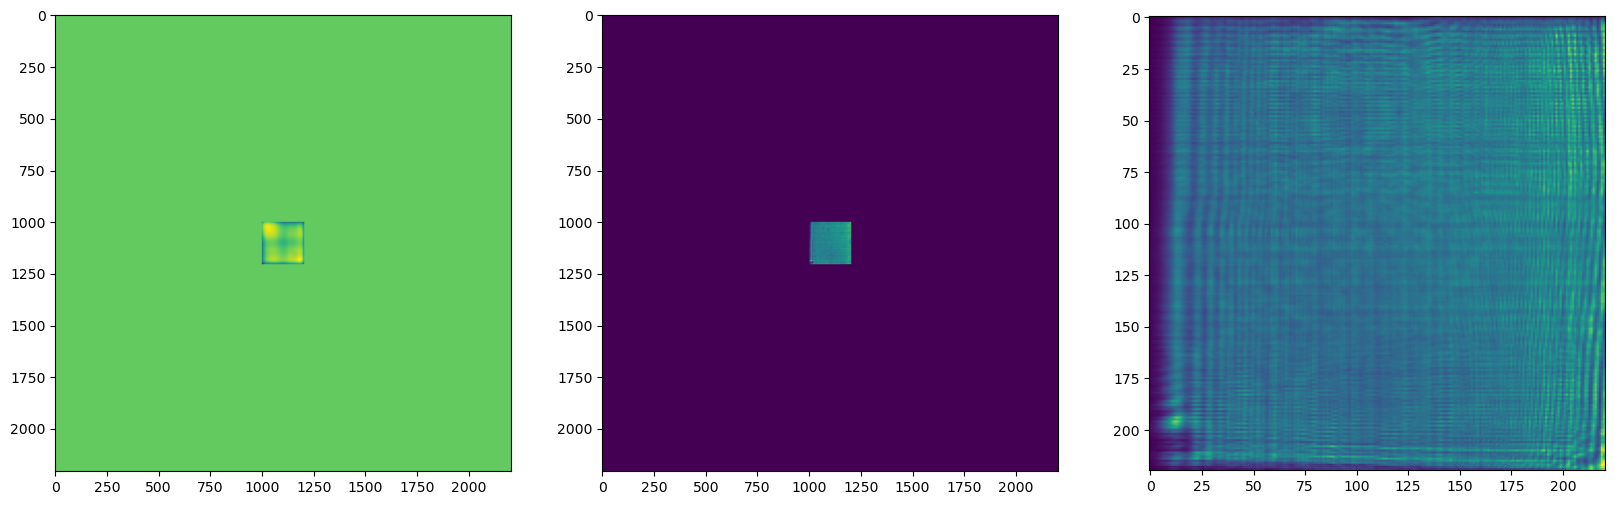

In [20]:
fig, ax = plt.subplots(1,3, figsize=(20,8))
ax[0].imshow(phase_pad)
ax[1].imshow(white_pad)
ax[2].imshow(whitefield)
plt.show()

In [21]:
counts_pupil = np.sum(whitefield_trim) # the scan was with exposure time of 1 s, so it is actually cps
print(f"Counts in the pupil are: {counts_pupil/1e8} * 1e8")

Counts in the pupil are: 0.47820392 * 1e8


In [22]:
nr_positions = 100
defoci_range = (-50e-6, 50e-6) # set the range of defoci to scan
defoci = np.linspace(defoci_range[0], defoci_range[-1], nr_positions)
PSFs = defocus_scan(phase_pad, white_pad, nr_positions, defoci_range, distance, pxsize, wavelength)

Starting the pool...
Defocus scan completed


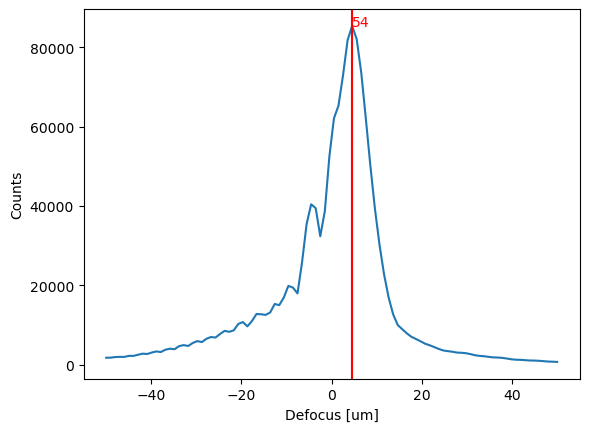

Maximum intensity found in PSF #54 in the PSFs stack, 
which corresponds to the defocus of 4.5 um


In [23]:
max_val = [PSFs[i].max() for i in range(nr_positions)]
result = np.where(max_val == np.amax(max_val)) # this should give the position of the maximum
fig, ax = plt.subplots()
ax.plot(defoci*1e6, max_val)
ax.axvline(defoci[result[0][0]]*1e6, color = "red")
ax.set_xlabel("Defocus [um]")
ax.set_ylabel("Counts")
ax.text(defoci[result[0][0]]*1e6, max_val[result[0][0]], f"{result[0][0]}", color = "red")
plt.show()
print(f"Maximum intensity found in PSF #{result[0][0]} in the PSFs stack, \nwhich corresponds to the defocus of {round(defoci[result[0][0]]*1e6,1)} um")

In [24]:
# cutting through center
caustics_y = PSFs[:,:, white_pad.shape[1]//2]
caustics_x = PSFs[:, white_pad.shape[0]//2,:]

# cutting through max intensity
coords_max = []
caustics_x_max = np.zeros((PSFs.shape[0], PSFs.shape[2]))
caustics_y_max = np.zeros((PSFs.shape[0], PSFs.shape[1]))

for i in range(nr_positions):
    fr = PSFs[i,:,:]
    index = np.where(fr == np.amax(fr))
    coord_max = (index[0][0], index[1][0])
    coords_max.append(coord_max)
    caustics_x_max[i] = PSFs[i,coord_max[0],:]
    caustics_y_max[i] = PSFs[i,:, coord_max[1]]

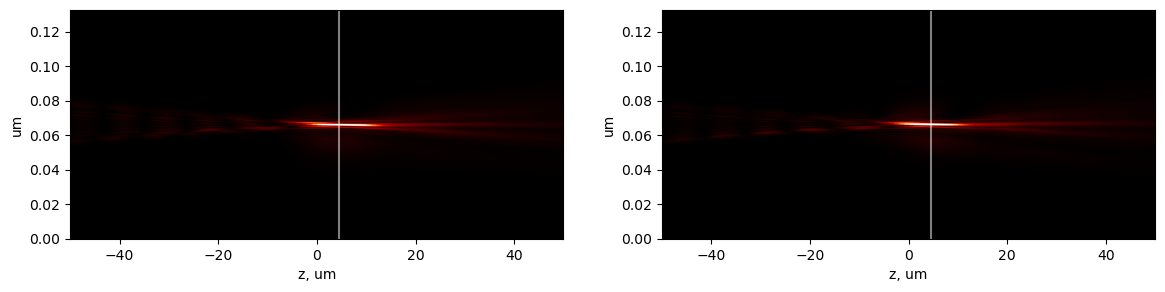

In [25]:
fig, axs = plt.subplots(1,2, figsize = (14,4))
gamma  = .7
max_counts = 3e4**gamma
extent = (defoci[0]*1e6, defoci[-1]*1e6, 0, NA * defoci[-1]*1e6)

axs[0].imshow(caustics_x.T**gamma,  vmax = max_counts, cmap = 'gist_heat', origin = "lower", extent = extent)
axs[1].imshow(caustics_y.T**gamma, vmax = max_counts, cmap = 'gist_heat', origin = "lower", extent = extent)
axs[0].axvline(defoci[result[0][0]]*1e6, color='white', alpha=0.5)
axs[1].axvline(defoci[result[0][0]]*1e6, color='white', alpha=0.5)
for ax in axs:
    ax.set_aspect(350)
    ax.set_xlabel("z, um")
    ax.set_ylabel("um")


Starting the pool...
Defocus scan completed
Maximum intensity found in PSF #50 in the PSFs stack, 
which corresponds to the defocus of 4.5 um


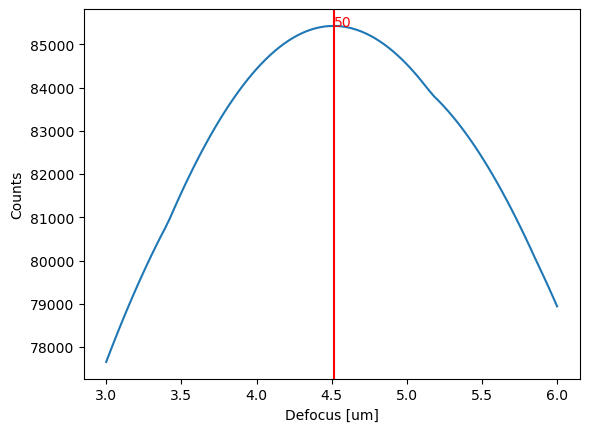

In [26]:
nr_positions = 100
defoci_range = (3e-6, 6e-6) # set the range of defoci to scan
defoci = np.linspace(defoci_range[0], defoci_range[-1], nr_positions)
PSFs = defocus_scan(phase_pad, white_pad, nr_positions, defoci_range, distance, pxsize, wavelength)

max_val = [PSFs[i].max() for i in range(nr_positions)]
result = np.where(max_val == np.amax(max_val)) # this should give the position of the maximum
fig, ax = plt.subplots()
ax.plot(defoci*1e6, max_val)
ax.axvline(defoci[result[0][0]]*1e6, color = "red")
ax.set_xlabel("Defocus [um]")
ax.set_ylabel("Counts")
ax.text(defoci[result[0][0]]*1e6, max_val[result[0][0]], f"{result[0][0]}", color = "red")
print(f"Maximum intensity found in PSF #{result[0][0]} in the PSFs stack, \nwhich corresponds to the defocus of {round(defoci[result[0][0]]*1e6,1)} um")

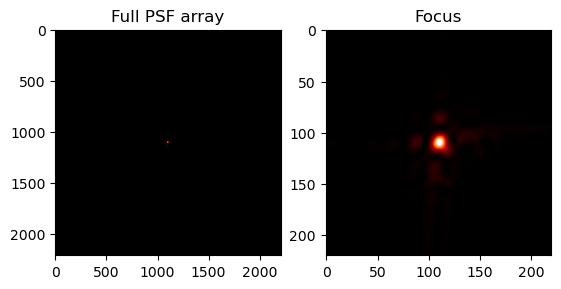

Maximum intensity in the PSF is 8.54e4 counts


In [27]:
k = result[0][0]# 42
max_counts = .8e5
PSF = PSFs[k]

fig, axs = plt.subplots(1,2,dpi=100)
# index of max intensity within the PSF array (slice in PSFs stack) with maximum maximum intensity
ind = np.unravel_index(np.argmax(PSF, axis=None), PSF.shape) 

enlarge = 0.05 # changes the "zoom" in the central region, smaller number, larger zoom

central_range = int(enlarge*(np.shape(phase_pad)[0] + np.shape(phase_pad)[1])/2) # selects a range around the focus based on the padded size

crop_PSF = PSF[ind[0]-central_range:ind[0]+central_range,ind[1]-central_range:ind[1]+central_range]

axs[0].imshow(PSF, cmap = 'gist_heat', vmax=max_counts)
axs[0].set_title("Full PSF array")
axs[1].imshow(crop_PSF, cmap = 'gist_heat', vmax=max_counts)
axs[1].set_title("Focus")
plt.show()

print(F"Maximum intensity in the PSF is {round(np.max(PSF)/1e4,2)}e4 counts") 

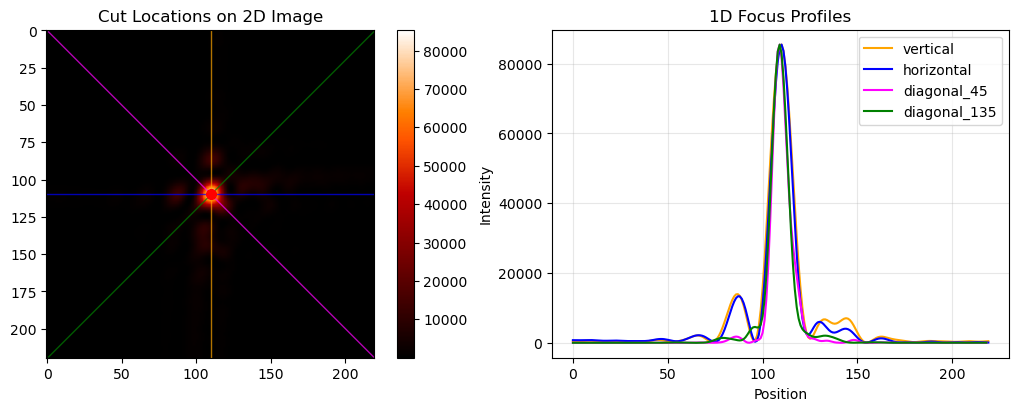

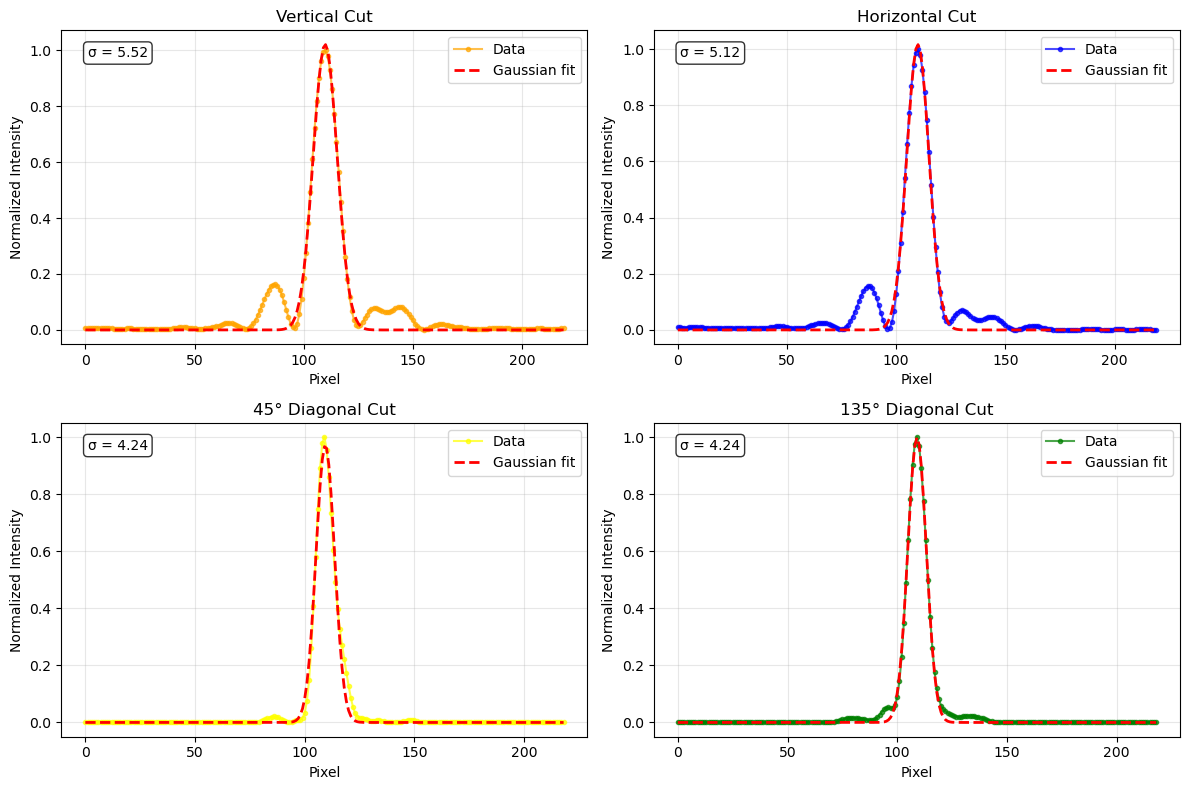


Gaussian Fitting Results:
Cut Name          | Amplitude | Center   | Sigma
--------------------------------------------------
vertical        |    1.020 |  109.83 |   5.52
horizontal      |    1.016 |  109.92 |   5.12
diagonal_45     |    0.971 |  109.38 |   4.24
diagonal_135    |    0.998 |  109.05 |   4.24

FWHM (Full Width at Half Maximum):
vertical       : 13.00 pixels
horizontal     : 12.06 pixels
diagonal_45    : 9.98 pixels
diagonal_135   : 9.99 pixels
Horizontal pixel size: 1.37e-09 m
Vertical pixel size: 1.37e-09 m

Physical Focus Sizes:
Direction        | Sigma (pixels) | FWHM (pixels) | Physical Size (nm)
----------------------------------------------------------------------
Vertical        |          5.52 |        12.99 |            17.8
Horizontal      |          5.12 |        12.06 |            16.5
45° Diagonal    |          4.24 |         9.98 |            13.6
135° Diagonal   |          4.24 |         9.99 |            13.7

Summary:
Average focus size: 15.4 nm
Size v

{'Vertical': np.float64(17.769681290539875),
 'Horizontal': np.float64(16.49056281307314),
 '45° Diagonal': np.float64(13.649280052179993),
 '135° Diagonal': np.float64(13.6600493290134),
 'virt_pxsize_hor': np.float64(1.3674809855694419),
 'virt_pxsize_vert': np.float64(1.3674809855694419)}

In [28]:
full_shape = PSF.shape
focus_data = get_focus_values(crop_PSF, full_shape, pxsize, wavelength, distance, plot = True, return_cuts = False)
focus_data

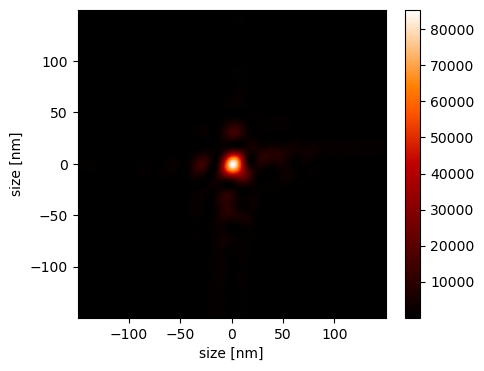

In [29]:
max_int = np.max(PSF)

# print(np.shape(crop_PSF))
X_ax = np.arange(np.shape(crop_PSF)[0])
X_ax = (X_ax - np.mean(X_ax))*focus_data["virt_pxsize_hor"]
Y_ax = np.arange(np.shape(crop_PSF)[1])
Y_ax = (Y_ax - np.mean(Y_ax))*focus_data["virt_pxsize_vert"]

fig, ax = plt.subplots( figsize=(5, 4), dpi=100)
im = ax.imshow(crop_PSF,cmap = 'gist_heat',extent=[X_ax[0],X_ax[-1],Y_ax[0],Y_ax[-1]],vmax=max_int)
ax.set_xlabel('size [nm]')
ax.set_ylabel('size [nm]')
plt.colorbar(im, ax = ax)
# plt.savefig("results/psf/scan_36/psf.png", bbox_inches = "tight", dpi = 100)
plt.show()


## Encircled energy plot

In [30]:
nr_positions = 100
defoci_range = (-50e-6, 50e-6) # set the range of defoci to scan
defoci = np.linspace(defoci_range[0], defoci_range[-1], nr_positions)
PSFs = defocus_scan(phase_pad, white_pad, nr_positions, defoci_range, distance, pxsize, wavelength)

Starting the pool...
Defocus scan completed


In [31]:
max_val = [PSFs[i].max() for i in range(nr_positions)]
k = np.where(max_val == np.amax(max_val))[0][0]
PSF = PSFs[k]

In [32]:
nr_points = 300 # how many circles
pix_size = np.mean((focus_data["virt_pxsize_hor"]*1e-9, focus_data["virt_pxsize_vert"]*1e-9))

# Find the coordinates of the brightest point in the entire stack
brightest_point_index = np.argmax(PSF)  # Brightest point in the stack
shape = PSF.shape
brightest_y, brightest_x = np.unravel_index(brightest_point_index, shape)
coords = brightest_x, brightest_y

max_rad = min(brightest_x, brightest_y, shape[1] - brightest_x, shape[0] - brightest_y)
radii = np.linspace(1, max_rad, nr_points)*pix_size*1e9

In [33]:
nr_points = 500
radii = np.linspace(1, max_rad, nr_points)*pix_size*1e9

image = PSF/np.sum(PSF)
brightest_point_index = np.argmax(image) # taking here the brighest point in the stack
shape = image.shape
brightest_y, brightest_x = np.unravel_index(brightest_point_index, shape)
coords = brightest_x, brightest_y
_, encircled_energy = get_encircled_energy(image, pix_size, coords = coords, nr_points = nr_points)


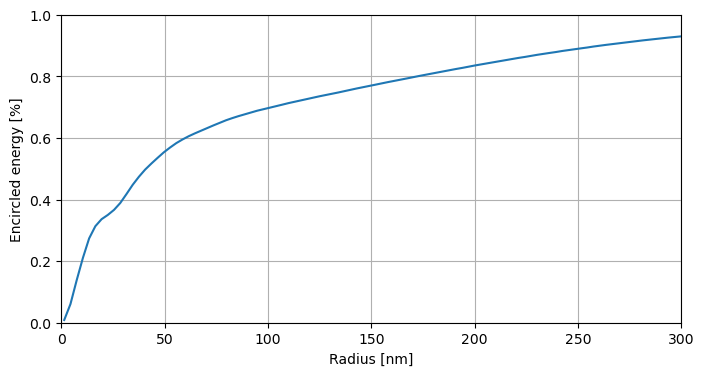

In [34]:
fig, ax = plt.subplots(figsize = (8,4))
ax.plot(radii, encircled_energy)
ax.set_xlim(0,300)
ax.set_ylim(0,1)
ax.grid()
ax.set_xlabel("Radius [nm]")
ax.set_ylabel("Encircled energy [%]")
plt.show()

In [35]:
encircled_energy_for_psfs = calculate_encircled_energy_parallel(
    PSFs, pix_size=pix_size, 
    coords=coords, 
    nr_points=nr_points
)

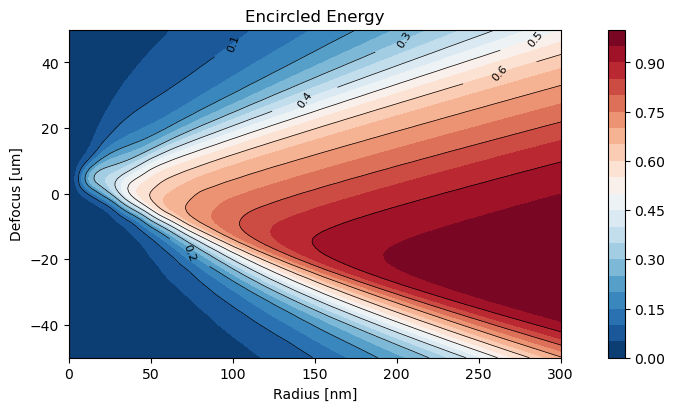

In [36]:
# Option 3: Combined filled + line contours
fig, ax = plt.subplots(figsize=(8, 4), constrained_layout=True, dpi=100)
# Filled contours
extent = radii[0], radii[-1], defoci[0]*1e6, defoci[-1]*1e6 
im = ax.contourf(encircled_energy_for_psfs, extent=extent, cmap="RdBu_r", levels=20)
# Line contours on top
cs = ax.contour(encircled_energy_for_psfs, extent=extent, levels=10, colors='black', linewidths=0.5)
ax.clabel(cs, inline=True, fontsize=8)

ax.set_aspect(2)
ax.set_xlabel("Radius [nm]")
ax.set_ylabel("Defocus [um]")
ax.set_xlim(0, 300)
plt.colorbar(im, ax=ax)
plt.title("Encircled Energy")
plt.show()